<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/LabTimeSeries_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

14/14 [==============================] - 0s 3ms/step - loss: 0.1392
Mean Squared Error on validation set: 0.13923676311969757
15/15 [==============================] - 0s 5ms/step
Losses after 10 epochs: [1.0343290567398071, 0.9910315871238708, 0.9496895670890808, 0.9123535752296448, 0.8785610198974609, 0.8459161520004272, 0.8166472911834717, 0.7888350486755371, 0.7631536722183228, 0.7394403219223022, 0.7172975540161133, 0.6965891718864441, 0.6770961880683899, 0.6591991782188416, 0.6423318386077881, 0.6266339421272278, 0.6115525364875793, 0.5977119207382202, 0.5850695371627808, 0.5727459192276001, 0.5612959861755371, 0.5502015948295593, 0.5396954417228699, 0.5297333002090454, 0.520304262638092, 0.5112224817276001, 0.5030181407928467, 0.494528204202652, 0.4869022071361542, 0.47947216033935547, 0.47230878472328186, 0.46573522686958313, 0.4590195417404175, 0.4529491066932678, 0.44701099395751953, 0.44147369265556335, 0.4360203146934509, 0.43075627088546753, 0.42593079805374146, 0.421096950

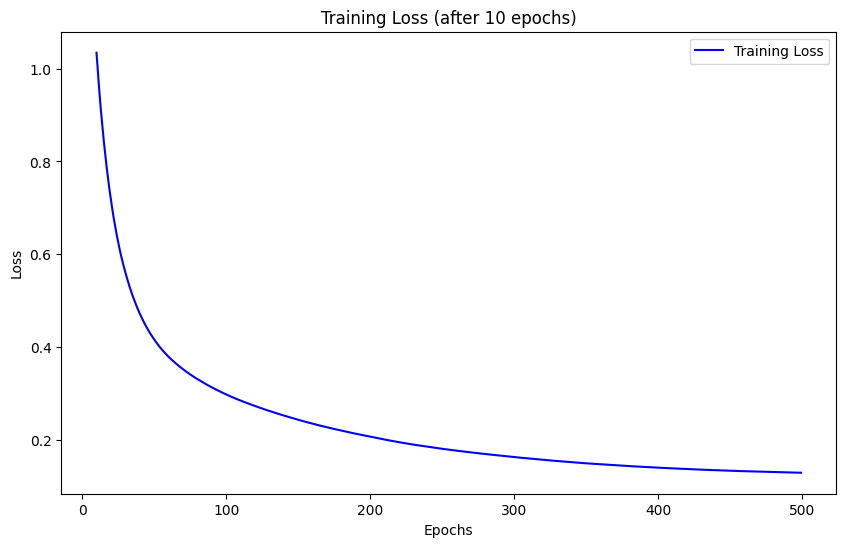

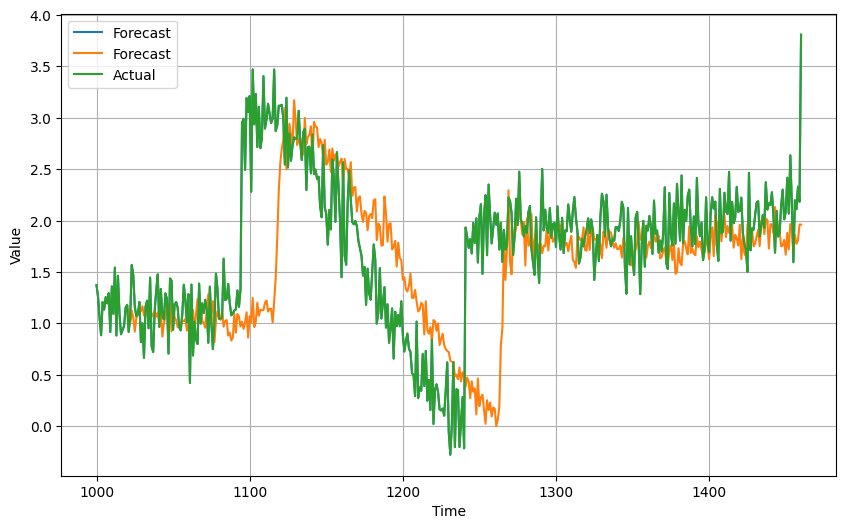

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Функции для генерации временного ряда и его визуализации
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Генерация временного ряда
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
year = 365

time = np.arange(4 * year + 1, dtype="float32")
series = baseline + trend(time, slope) + seasonality(time, period=year, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

# Функция для прогнозирования и визуализации результатов
def forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

def plot_forecast(time, series, forecast, format="-", start=0, end=None, label=None):
    if end is None:
        end = len(time)
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.plot(time[start+window_size:end], forecast[start:end-window_size], format, label="Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

# Проверка на NaN значения в данных
assert not np.isnan(series).any(), "Data contains NaN values"

# Нормализация данных
mean = series[:1000].mean()
std = series[:1000].std()
series = (series - mean) / std

# Разделение данных на тренировочные и валидационные наборы
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Функция для создания набора данных с окнами
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Создание многослойной нейронной сети
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Компиляция модели с оптимальным значением learning_rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))
history = model.fit(train_set, epochs=500, verbose=0)

# Оценка модели на валидационном наборе
validation_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
mse = model.evaluate(validation_set)
print("Mean Squared Error on validation set:", mse)

# Прогнозирование и визуализация результатов
forecast_series = forecast(model, series[split_time - window_size:-1], window_size)
forecast_series = forecast_series.flatten()

loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print("Losses after 10 epochs:", plot_loss)
plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.title("Training Loss (after 10 epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plot_forecast(time_valid, x_valid, forecast_series, label="Forecast")
plot_series(time_valid, x_valid, label="Actual")
plt.legend()
plt.show()